**Due date is Wednesday, March 10, 2021, 23:59 PST**

**ONLY write into the existing cells, and do NOT delete or add any cells.**

# ELEC 400M / EECE 571M Assignment 2: Neural networks
(This assignment is a modified version of an assignment used in ECE 421 at the University of Toronto and kindly made available to us by the instructor.)

In this assignment, you will implement a neural network model for multi-class classification. The purpose is to demonstrate an understanding of the basic elements including training of neural network models. Hence, your implementation will be from scratch only using functions from the NumPy library.

The neural network you will be implementing has the following structure:
* 1 input layer, 1 hidden layer with ReLU activation and 1 output layer with Softmax function
* The loss function is the Cross Entropy Loss.
* Training will be done using Gradient Descent with Momentum. 

## Data Set
We again consider the dataset of images of letters in different fonts contained in file notMNIST.npz (which btw is from http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html). This time we consider 10 letters ("A" to "J"), which are all the letters contained in this data set, and we want to classfiy the images according to the letter they display. The figure below shows 30 randomly selected image samples for the letters.

<img src="sample_images_2.png" width="400">

You will apply the function `loadData` given below to load the data set, which includes 18720 images and their labels, which we also refer to as **targets**. This script organizes the data set into training, validation and test sets. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def loadData():
    with np.load('notMNIST.npz') as data:
        Data, Target = data['images'], data['labels']
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx]/255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:15000], Target[:15000]
        validData, validTarget = Data[15000:16000], Target[15000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
       
    return trainData, validData, testData, trainTarget, validTarget, testTarget

## Data preprocessing [5 points]

Input data: The classification should be based on the $d=28\times 28=784$ intensity values in an image (as for Assignment 1).

Output data: Since you will be performing multi-class classification, the labels will be converted into a one-hot encoding format. 

Please first briefly explain the meaning of one-hot encoding and why it is used (instead of keeping the numerical label values provided by the data set). State an example for a one-hot encoded label for the data set considered in this assignment. Use the text cell below for this. 

After that, implement a function that one-hot encodes the labels (or targets) for the training, validation and test sets

1. **Meaning of one-hot encoding**: for each sample, the label is a $(c+1) \times 1$ vector with each element corresponds to one class. For mutli-class classification, each label has one element being 1, the other elements being 0. 
2. **Why it is used**: compared with numerical label values, a one-hot-key label 1) does not imply distance among classes, or ordering of classes. 2) Also with numerical label values, having a large number of classes would lead to the range of label values to be fairly large. Then finding weights would be difficult.
3. Example: For letter 'A', the one-hot-key encoding would be $$\begin{bmatrix}
           1 \\
           0 \\
           \vdots \\
           0
         \end{bmatrix}.$$ The vector has 10 rows, and the 0's in the 7 rows in the middle are omitted.

In [3]:
def convertOneHot(trainTarget, validTarget, testTarget):
    # YOUR CODE HERE
    """
    Returns a tuple of three one-hot target matrices, each of dim 
    c x N_i, where c is the number of classes, N_i is the number 
    of samples in each set
    """
    # initialize one-hot target matrices
    trainTargetOneHot = np.zeros((10, trainTarget.shape[0]))
    validTargetOneHot = np.zeros((10, validTarget.shape[0]))
    testTargetOneHot = np.zeros((10, testTarget.shape[0]))
    
    # build one-hot target matrices
    targetList = [trainTarget, validTarget, testTarget]
    targetOneHotList = [trainTargetOneHot, validTargetOneHot, testTargetOneHot]
    for i in range(0, len(targetList)):
        target = targetList[i]
        targetOneHot = targetOneHotList[i]
        for col in range(0, len(target)):
            targetOneHot[target[col], col] = 1
        
    return (trainTargetOneHot, validTargetOneHot, testTargetOneHot)

# test code
from PIL import Image
from IPython.display import Image as ImageIPy
from IPython.display import display

trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

#print(trainData[0].shape)
#trainData0Img = Image.fromarray((trainData[0] * 255).astype('uint8'), mode='L')
#trainData0Img.save('trainData0Img.png', 'png')
#display(ImageIPy(filename='trainData0Img.png'))
#validData9Img = Image.fromarray((validData[9] * 255).astype('uint8'), mode='L')
#validData9Img.save('validData9Img.png', 'png')
#display(ImageIPy(filename='validData9Img.png'))

trainTargetOneHot, validTargetOneHot, testTargetOneHot = convertOneHot(trainTarget, validTarget, testTarget)

# check train[0]
trainTargetOneHot0Expected = np.zeros((10,))
trainTargetOneHot0Expected[5] = 1
assert np.linalg.norm(np.subtract(trainTargetOneHot[:, 0], trainTargetOneHot0Expected))<0.01

# check valid[9]
validTargetOneHot9Expected = np.zeros((10,))
validTargetOneHot9Expected[2] = 1
assert np.linalg.norm(np.subtract(validTargetOneHot[:, 9], validTargetOneHot9Expected))<0.01

## Structure of the network [2 points]

Sketch the structure of the network to classify the letters from the data set. Identify the dimensions of the network layers, include the activation functions, and do not forget the bias nodes. (You may sketch this by hand and upload a photo of your sketch.)

![structure](asst3_structure_new2.png)

## Helper functions [6 points]
To give the implementation of the network some structure, you will first implement five helper functions. 

Use Numpy arrays for your implementations, and organize data in vectors and matrices as appropriate for compact programming (i.e., avoid `for` loops).

1. `relu`: This function will accept one argument and return the ReLU activation: 
    $$\mathrm{ReLU}(x)=\max(0,x).$$
    
2. `softmax`: This function will accept one argument and return the softmax activations:
    $$ [\sigma(\mathbf{z})]_j = \frac{\mathrm{e}^{z_j}}{\sum\limits_{k=1}^K\mathrm{e}^{z_k}},$$ $j=1,2,\ldots, K$,  for $K$ classes.
    
You may want to program the `relu` and the `softmax` functions that you call them once for all $N$ samples to be processed.    

3. `computeLayer`: This function will accept two arguments, the input vectors $\mathbf{x}^{(\ell-1)}_n$ and the weight matrix $\mathbf{W}^{(\ell)}$ for a layer $\ell$, and return the vectors $\mathbf{s}_n^{(\ell)}=(\mathbf{W}^{(\ell)})^T\mathbf{x}_n^{(\ell)}$, $n=1,2,\ldots,N$, i.e., the inputs to the activation function of that layer (the notation for variables from the textbook is used). Don't forget to account for the bias term (which can be included in augmented vectors $\mathbf{x}^{(\ell)}_n$ as in the textbook).

4. `CE`: This function will accept two arguments, the one-hot encoded labels $\mathbf{y}_n$ and the inputs $\mathbf{s}_n$ to the softmax function, $n=1,2,\ldots, N$. It will return the average cross entropy loss
$$\mathrm{E}_{\mathrm{in}}=-\frac{1}{N}\sum\limits_{n=1}^N\sum\limits_{k=1}^Ky_{n,k}\log([\sigma(\mathbf{s}_n)]_k)$$

5. `gradCE`: This function will accept two arguments, the one-hot encoded labels $\mathbf{y}_n$ and the inputs $\mathbf{s}_n$ to the softmax function, $n=1,2,\ldots, N$. It will return the gradients of the cross entropy loss for each data sample with respect to $\mathbf{s}_n$, i.e., it returns the sensivity vectors for the output layer as introduced in the textbook:
$$\boldsymbol{\mathbf{\delta}}^{(L)}_n=\frac{\partial e_n}{\partial \mathbf{s}_n^{(L)}},\quad n=1,2,\ldots,N.$$. 

First state the analytical expression for the gradient used in `gradCE` and then implement the five helper functions.

Here we discuss two cases: 1) For the last layer, as required by the helper function, where $l=L$, and 2) For the hidden layers, where $1 \leq l < L$. 
1. **For the last layer where $l=L$.** For any sample $n$, the loss with respect to $\mathbf{s}_n^{(L)}$ is $$e_n = -\sum\limits_{k=1}^Ky_{n,k}\log([\sigma(\mathbf{s}_n^{(L)})]_k).$$ After calculating derivatives, we can get its derivative with respect to $\mathbf{s}_n^{(L)}$: $$\boldsymbol{\mathbf{\delta}}^{(L)}_n = \frac{\partial e_n}{\partial \mathbf{s}_n^{(L)}} =  \mathbf{x}_n^{(L)} - \mathbf{y}_n.$$ This is a $d^{(L)} \times 1$ vector. Since we have 10 classes, $d^{(L)} = 10$.

2. **For the hidden layers where $1 \leq l < L$**. Here we want to compute the sensitivity vector $\boldsymbol{\mathbf{\delta}}^{(l)}_n$ for any node in the hidden layers. So we have $$\boldsymbol{\mathbf{\delta}}^{(l)}_n = \frac{\partial e_n}{\partial \mathbf{s}_n^{(l)}} = \frac{\partial e_n}{\partial \mathbf{x}_n^{(l)}}\frac{\partial \mathbf{x}_n^{(l)}}{\partial \mathbf{s}_n^{(l)}} = [\mathbf{W}^{(l+1)}\boldsymbol{\mathbf{\delta}}_n^{(l+1)}]_{1}^{d(l+1)} \otimes \{\mathbf{s}_n^{(l)}>=0\}, $$ where $\boldsymbol{\mathbf{\delta}}^{(l+1)}_n$ is a $d^{(l+1)} \times 1$ vector, $\otimes$ stands for element-wise multiplication, and $\{\mathbf{s}_n^{(l)}>=0\}$ is the derivative of the ReLU activation function at layer $l$ which takes a binary value in $\{0, 1\}$. In our network, for the hidden layer we only have $l=1$ and $l+1=2=L$. So the equation becomes $$\boldsymbol{\mathbf{\delta}}^{(1)}_n = \frac{\partial e_n}{\partial \mathbf{s}_n^{(1)}} = \frac{\partial e_n}{\partial \mathbf{x}_n^{(1)}}\frac{\partial \mathbf{x}_n^{(1)}}{\partial \mathbf{s}_n^{(1)}} = [\mathbf{W}^{(L)}\boldsymbol{\mathbf{\delta}}_n^{(L)}]_{1}^{d(L)} \otimes \{\mathbf{s}_n^{(1)}>=0\}. $$

In [4]:
def relu(x):
    # YOUR CODE HERE
    """Takes array x of arbitrary shape, returns max(0, x)
    of the same shape
    """
    return np.maximum(x, 0)

# test code
# check one sample, 1 dim array
s = np.array([-2, -1, 0, 1, 2])
x = relu(s)
xExpected = np.array([0, 0, 0, 1, 2])
assert np.linalg.norm(np.subtract(x, xExpected))<0.01

# check one sample, 4x1 array
s = np.array([[3],[2],[0],[-4]])
x = relu(s)
xExpected = np.array([[3],[2],[0],[0]])
assert np.linalg.norm(np.subtract(x, xExpected))<0.01

# check two samples
s = np.array([[3, 1],[2, 0],[0, 9],[-4, -3]])
x = relu(s)
xExpected = np.array([[3, 1],[2, 0],[0, 9],[0, 0]])
assert np.linalg.norm(np.subtract(x, xExpected))<0.01

In [5]:
def softmax(x):    
    # YOUR CODE HERE
    """
    Returns the softmax of x, as a vector with same shape
    as x. 
    x should be of shape (c, N) where c is the number of classes.
    """
    exp = np.exp(x-np.ndarray.max(x))
    denos = np.sum(exp, axis=0)
    softmax = exp / denos
    return softmax

# test code
# check one sample
s = np.array([[3],[2],[0],[-4]])
x = softmax(s)
xExpected = np.array([[0.7049],[0.2593],[0.0350],[6.4281e-4]])
assert np.linalg.norm(np.subtract(x, xExpected))<0.01

# check two samples
s = np.array([[3, 2],[4, 8], [1, 3]])
x = softmax(s)
xExpected = np.array([[0.2594, 0.002456],[0.7053, 0.9908],[0.0351, 0.006676]])
assert np.linalg.norm(np.subtract(x, xExpected))<0.01

In [6]:
def computeLayer(x,W):
    # YOUR CODE HERE
    """
    Computes W^T * x.
    Inputs:
    - x: vector of shape (d(l-1), N)
    - W: vector of shape (d(l-1)+1, d(l))
    Returns:
    - s(l) of shape (d(l), N).
    """
    xNew = np.insert(x, 0, 1.0, axis=0)
    s = np.matmul(np.transpose(W), xNew)
    return s

# test code
# check one sample
W = np.array([[5, 2, 1],[1, 3, 4],[2, 1, 9],[6, 7, 8]])
x = np.array([[4],[3],[5]])
s = computeLayer(x, W)
sExpected = np.array([[45],[52],[84]])
assert np.linalg.norm(np.subtract(s, sExpected))<0.01

# check two samples
W = np.array([[5, 2, 1],[1, 3, 4],[2, 1, 9],[6, 7, 8]])
x = np.array([[4, 1],[3, 2],[5, 2]]) # transposed data matrix
s = computeLayer(x, W)
sExpected = np.array([[45, 22],[52, 21],[84, 39]])
assert np.linalg.norm(np.subtract(s, sExpected))<0.01

In [7]:
def CE(target, softmaxinput):
    # YOUR CODE HERE
    """
    Computes the average cross-entropy across N samples.
    Inputs:
    - target: one-hot coded target matrix with shape (c, N)
    - softmaxinput: inputs to the softmax layer of shape (c, N)
    Returns:
    - E_in as a scalar
    """
    smaxout = softmax(softmaxinput)
    e = np.sum(np.multiply(target, np.log(smaxout)), axis=0, keepdims=True)
    N = target.shape[1]
    E = -1.0/N * np.sum(e, axis=1)
    return E[0]
    
# test code
# check one sample
y = np.array([[0],[1],[0]])
s = np.array([[3],[4],[1]])
E = CE(y, s)
EExpected = 0.34902
assert np.linalg.norm(np.subtract(E, EExpected))<0.01

# check two samples
y = np.array([[0, 1],[1, 0],[0, 0]])
s = np.array([[3, 2],[4, 8],[1, 3]])
E = CE(y, s)
EExpected = 3.1791
assert np.linalg.norm(np.subtract(E, EExpected))<0.01

In [8]:
def gradCE(target, softmaxinput):
    # YOUR CODE HERE
    """
    Returns the sensitivity vectors from the output layer.
    Inputs:
    - target: one-hot coded target matrix with shape (d(L), N)
    - softmaxinput: inputs to the softmax layer of shape (d(L), N)
    Returns:
    - the (d(L), N) sensitivity vector for all N samples
    """
    #print(f"target: {target}")
    xL = softmax(softmaxinput)
    #print(f"xL: {xL}")
    sens = xL - target
    #print(f"sensL: {sens}")
    return sens

# test code
# check one sample
y = np.array([[0],[1],[0]])
sL = np.array([[2],[5],[3]])
sens = gradCE(y, sL)
h = 1e-9
dEds1L = (CE(y, np.array([[2+h],[5],[3]])) - CE(y, np.array([[2-h],[5],[3]]))) / (2*h)
dEds2L = (CE(y, np.array([[2],[5+h],[3]])) - CE(y, np.array([[2],[5-h],[3]]))) / (2*h)
dEds3L = (CE(y, np.array([[2],[5],[3+h]])) - CE(y, np.array([[2],[5],[3-h]]))) / (2*h)
sensNumer = np.array([[dEds1L], [dEds2L], [dEds3L]])
assert np.linalg.norm(np.subtract(sens, sensNumer))<0.01

# check one sample
y = np.array([[0],[1],[0]], dtype=np.float64)
sL = np.array([[500],[1],[2]], dtype=np.float64)
sens = gradCE(y, sL)
h = 1e-9
dEds1L = (CE(y, np.array([[500+h],[1],[2]])) - CE(y, np.array([[500-h],[1],[2]]))) / (2*h)
dEds2L = (CE(y, np.array([[500],[1+h],[2]])) - CE(y, np.array([[500],[1-h],[2]]))) / (2*h)
dEds3L = (CE(y, np.array([[500],[1],[2+h]])) - CE(y, np.array([[500],[1],[2-h]]))) / (2*h)
sensNumer = np.array([[dEds1L], [dEds2L], [dEds3L]])
assert np.linalg.norm(np.subtract(sens, sensNumer))<0.01

## Backpropagation [2 points]

The training of the network will be done via backpropagation. First derive the following gradients:
1. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{o}}}$, where $\mathbf{W}^{\mathrm{o}}$ is the weight matrix of the output layer.

2. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{h}}}$, where $\mathbf{W}^{\mathrm{h}}$ is the weight matrix of the hidden layer.

Write the results using the steps and notation used in the textbook.

1. We know from Equation 7.3 and 7.4 from the textbook that
$$\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{(L)}} = \frac{1}{N}\sum_{n=1}^{N} \frac{\partial e_n}{\partial \mathbf{W}^{(L)}} = \frac{1}{N}\sum_{n=1}^{N} \mathbf{x}_{n}^{(L-1)}(\boldsymbol{\mathbf{\delta}}_{n}^{(L)})^T,$$ where $\mathbf{x}_{n}^{(L-1)}$ is a $(d^{(L-1)}+1) \times 1$ vector of the output from the hidden layer, and $\boldsymbol{\mathbf{\delta}}_{n}^{L}$ is the $d^{(L)} \times 1$ sensitivity vector of the last layer. The summation is element-wise. We can further vectorize this expression across $N$ samples: 
$$\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{(L)}} = \frac{1}{N}\mathbf{X}^{(L-1)}(\boldsymbol{\mathbf{\delta}}^{(L)})^T = \frac{1}{N}\mathbf{X}^{(L-1)}(\mathbf{X}^{(L)}-\mathbf{Y})^T,$$ 
where $\mathbf{X}^{(L-1)}$ is a $(d^{(L-1)}+1) \times N$ matrix and $\boldsymbol{\mathbf{\delta}}^{(L)}$ is a $d^{(L)} \times N$ matrix of sensitivity vectors at level $L$ for all $N$ samples.

2. The hidden layer has $l=1$. So we have
$$\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{(1)}} = \frac{1}{N}\mathbf{X}^{(0)}(\boldsymbol{\mathbf{\delta}}^{(1)})^T = \frac{1}{N}\mathbf{X}^{(0)}([\mathbf{W}^{(L)}\boldsymbol{\mathbf{\delta}}^{(L)}]_{1}^{d(L)} \otimes \{\mathbf{s}^{(1)}>=0\})^T,$$ where $\mathbf{X}^{(0)}$ is a $(d^{(0)} + 1) \times N$ input matrix.

## Network training [8 points]

Implement a function to train the network. The function uses the helper functions from above. The optimization technique for backpropagation will be Gradient Descent with Momentum (i.e., we consider batch gradient descent, using all data samples for computing the gradient):
$$\mathbf{V}(t)=\alpha \mathbf{V}(t-1)-\eta\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}(t)}$$
and 
$$\mathbf{W}(t+1)=\mathbf{W}(t)+\mathbf{V}(t),$$
where $\eta$ is the learning rate and $\alpha$ is the momentum hyperparameter.

The training function accepts the following inputs:  training data (features), training labels (targets), weight matrix of the hidden layer, weight matrix of the output layer, number of iterations (which is equal to the number of epochs as we consider batch gradient descent), parameters $\eta$ and $\alpha$, validation data, validation labels, test data, test labels. The validation and test inputs are initialized to "None" and need not be passed on. You will also need to initialize the velocity matrices $\mathbf{V}$ for both hidden layer and output layer weights to small values, e.g. $10^{-5}%$.

The function outputs the updated weight matrices after training, the CE loss and the classification accuracy for the training data as a function of the iteration, and if validation and test inputs were provided, then it also outputs the classification accuracies for the validation and test data as functions of the iteration,.

In [24]:
# YOUR CODE HERE
from IPython.display import display, clear_output

def gradWOutput(x1, sensL):
    """
    Returns dE_in/dW_L without normalizing by 1/N.
    Inputs:
    - x1: output from hidden layer, a (d(1), N) array
    - sensL: sensitivity matrix of output layer, a (d(L), N) array
    Returns:
    - gradients as a (d(1)+1, d(L)) array
    """
    #print(f"sensL: {sensL}")
    x1AndOne = np.insert(x1, 0, 1.0, axis=0)
    #print(f"x1AndOne: {x1AndOne}")
    dEdWL = np.matmul(x1AndOne, np.transpose(sensL))
    #print(f"shape of dEdWL: {dEdWL.shape}")
    #print(f"dEdWL: {dEdWL}")
    return dEdWL

def gradWHidden(x0, wL, sensL, s1):
    """
    Returns dE_in/dW_1 without normalizing by 1/N.
    Inputs:
    - x0: input to the network, a (d(0), N) array
    - wL: weights of the output layer, a (d(1)+1, d(L)) array
    - sensL: sensitivity matrix of the output layer, a (d(L), N) array
    - s1: input to the hidden layer, a (d(1), N) array
    Returns:
    - gradients as a (d(0)+1, d(1)) array
    """
    x0AndOne = np.insert(x0, 0, 1.0, axis=0) # (d(0)+1, N)
    wSensL = np.matmul(wL, sensL)[1:, :] # (d(1), N)
    dReludSens = s1>=0 # (d(1), N)
    wSensLdReludSens = np.multiply(wSensL, dReludSens) # (d(1), N)
    dEdW1 = np.matmul(x0AndOne, np.transpose(wSensLdReludSens)) #(d(0)+1, d(1))
    return dEdW1

def forwardProp(x0, w1, wL):
    """
    Forward propagate on our network.
    Inputs:
    - x0: input data matrix of shape (d(0), N)
    - w1: hidden layer weight matrix of shape (d(0)+1, d(1))
    - wL: output layer weight matrix of shape (d(1)+1, d(L))
    Returns:
    - s1: input to hidden layer of shape (d(0)+1, N)
    - x1: output from hidden layer of shape (d(1), N)
    - s2: input to output layer of shape (d(1)+1, N)
    - x2: output from output layer of shape (d(L), N)
    """
    assert(x0.shape[0]+1 == w1.shape[0])
    s1 = computeLayer(x0, w1)
    x1 = relu(s1)
    s2 = computeLayer(x1, wL)
    x2 = softmax(s2)
    return (s1, x1, s2, x2)

def computeAccuracy(trueTarget, softmaxOut):
    """
    Returns the accuracy of predictions, given actual and predicted
    target one-hot matrices of same shape (c, N).
    """
    # compute predicted targets with softmaxOut
    predIndices = np.argmax(softmaxOut, axis=0)
    predTarget = np.zeros(softmaxOut.shape)
    predTarget[predIndices, range(0, predTarget.shape[1])] = 1.0
    
    # compute a (1, N) matrix in which each element is 1) 1 if pred.
    # is correct, 2) 0 if not
    compareMat = np.sum(np.multiply(trueTarget, predTarget), axis=0, keepdims=True)
    
    # compute accuracy
    acc = np.sum(compareMat, axis=1)[0] / float(compareMat.shape[1])
    return acc

def train(trainData, trainTarget, WHidden, WOutput, numIter, eta, alpha, validData=None, validTarget=None, testData=None, testTarget=None):
    """
    Train a neural network with one hidden layer and one output layer for the
    given number of iterations, using the given training data.
    
    Inputs:
    - trainData:                training features as a (d(0), N) matrix, where d(0) is the number
                                of features
    - trainTarget:              training target as a (d(L), N) one-hot-encoded matrix
    - WHidden:                  initial hidden layer weights as a (d(0)+1, d(1)) matrix
    - WOutput:                  initial output layer weights as a (d(1)+1, d(L)) matrix
    - numIter:                  number of training epochs
    - eta:                      learning rate
    - alpha:                    momentum hyperparameter
    - validData (optional):     validation features as a (d(0), N') matrix
    - validTarget (optional):   validation target as a (d(L), N') matrix
    - testData (optional):      test features as a (d(0), N'') matrix
    - testTarget (optional):    test target as a (d(L), N'') matrix
    
    Returns:
    - the final weights of the hidden layer
    - the final weights of the output layer
    - list of training CE losses over iterations
    - list of training accuracies over iterations
    - (if validation data provided) list of validation accuracies over iterations
    - (if test data provided) list of test accuracies over iterations
    """
    # initialize the velocity matrices
    WHiddenCpy = np.copy(WHidden)
    WOutputCpy = np.copy(WOutput)
    VHidden = 1e-5 * np.ones(WHiddenCpy.shape)
    VOutput = 1e-5 * np.ones(WOutputCpy.shape)
    
    # initialize losses and accuracies
    trainLosses = []
    trainAccs = []
    validAccs = []
    testAccs = []
    
    # train for numIter epochs    
    for epoch in range(0, numIter):
        
        # forward prop on training set to prepare values for backprop
        s1, x1, s2, x2 = forwardProp(trainData, WHiddenCpy, WOutputCpy)
        
        # compute weight gradients (without normalizing by 1/N)
        sensOutput = gradCE(trainTarget, s2)
        dEdWOutput = gradWOutput(x1, sensOutput)
        dEdWHidden = gradWHidden(trainData, WOutputCpy, sensOutput, s1)
        
        # backprop to update weights
        VOutput = alpha * VOutput - eta * dEdWOutput
        VHidden = alpha * VHidden - eta * dEdWHidden
        WOutputCpy = WOutputCpy + VOutput
        WHiddenCpy = WHiddenCpy + VHidden
        
        # forward prop again to compute loss and accuracies
        # forward prop on training set
        s1, x1, s2, x2 = forwardProp(trainData, WHiddenCpy, WOutputCpy)
        # forward prop on valid set
        s2V = None
        x2V = None
        if (validData is not None) and (validTarget is not None):
            _, _, s2V, x2V = forwardProp(validData, WHiddenCpy, WOutputCpy)
        # forward prop on test set
        s2T = None
        x2T = None
        if (testData is not None) and (testTarget is not None):
            _, _, s2T, x2T = forwardProp(testData, WHiddenCpy, WOutputCpy)
        
        # compute loss (for training set only)
        trainLoss = CE(trainTarget, s2)
        trainLosses.append(trainLoss)
        
        # display which iteration we are at and report loss. Idea from
        # https://stackoverflow.com/questions/38540395/overwrite-previous-output-in-jupyter-notebook
        #clear_output(wait=True)
        #display(f"Iteration {epoch}, loss: {trainLoss}")
        
        # compute (and display at last epoch) accuracies
        trainAcc = computeAccuracy(trainTarget, x2)
        trainAccs.append(trainAcc)
        if epoch == numIter-1:
            print(f"Final training accuracy: {(100 * trainAcc):.2f}%")
        if (validData is not None) and (validTarget is not None):
            validAcc = computeAccuracy(validTarget, x2V)
            validAccs.append(validAcc)
            if epoch == numIter-1:
                print(f"Final validation accuracy: {(100 * validAcc):.2f}%")
        if (testData is not None) and (testTarget is not None):
            testAcc = computeAccuracy(testTarget, x2T)
            testAccs.append(testAcc)
            if epoch == numIter-1:
                print(f"Final test accuracy: {(100 * testAcc):.2f}%")
    
    # return stuff
    # only training data provided
    if (validData is None) and (validTarget is None) and (testData is None) and (testTarget is None):
        return (WHiddenCpy, WOutputCpy, trainLosses, trainAccs)
    # both training and valid data provided
    elif (testData is None) and (testTarget is None):
        return (WHiddenCpy, WOutputCpy, trainLosses, trainAccs, validAccs)
    # training, valid and test data provided
    else:
        return (WHiddenCpy, WOutputCpy, trainLosses, trainAccs, validAccs, testAccs)

# test code
def computeNumGrads(data, target, wH, wO, h):
    """
    Compute numerical gradients dE_in/dW_h and dE_in/dW_o.
    """
    # compute dE_in/dW_o
    dEdWO = np.zeros(wO.shape)
    for row in range(0, dEdWO.shape[0]):
        for col in range(0, dEdWO.shape[1]):
            wOPlusH = np.copy(wO)
            wOPlusH[row, col] = wOPlusH[row, col] + h
            _, _, s2PlusH, _ = forwardProp(data, wH, wOPlusH)
            EPlusH = CE(target, s2PlusH)
            wOMinusH = np.copy(wO)
            wOMinusH[row, col] = wOMinusH[row, col] - h
            _, _, s2MinusH, _ = forwardProp(data, wH, wOMinusH)
            EMinusH = CE(target, s2MinusH)
            dEdWO[row, col] = (EPlusH - EMinusH) / (2*h)
    # compute dE_in/dW_h
    dEdWH = np.zeros(wH.shape)
    for row in range(0, dEdWH.shape[0]):
        for col in range(0, dEdWH.shape[1]):
            wHPlusH = np.copy(wH)
            wHPlusH[row, col] = wHPlusH[row, col] + h
            _, _, s2PlusH, _ = forwardProp(data, wHPlusH, wO)
            EPlusH = CE(target, s2PlusH)
            wHMinusH = np.copy(wH)
            wHMinusH[row, col] = wHMinusH[row, col] - h
            _, _, s2MinusH, _ = forwardProp(data, wHMinusH, wO)
            EMinusH = CE(target, s2MinusH)
            dEdWH[row, col] = (EPlusH - EMinusH) / (2*h)
    return (dEdWH, dEdWO)
            
# set up
data = np.array([[5, 1], [2, 3]], dtype=np.float64)
target = np.array([[1, 1], [0, 0]], dtype=np.float64)
wH = np.array([[3, 4], [7, 8], [1, 3]], dtype=np.float64)
wO = np.array([[2, 6], [1, 4], [1, 5]], dtype=np.float64)
h = 1e-9

# check gradWOutput, gradWHidden
dEdWHNum, dEdWONum = computeNumGrads(data, target, wH, wO, h)
s1, x1, s2, x2 = forwardProp(data, wH, wO)
sensO = gradCE(target, s2)
dEdWOAna = (1.0 /data.shape[1]) * gradWOutput(x1, sensO)
dEdWHAna = (1.0 /data.shape[1]) * gradWHidden(data, wO, sensO, s1)
assert np.linalg.norm(np.subtract(dEdWONum, dEdWOAna))<0.01
assert np.linalg.norm(np.subtract(dEdWHNum, dEdWHAna))<0.01

# check computeAccuracy
trueTar = np.array([[1, 0, 0], [0, 1, 1]])
predTar = np.array([[0.8, 0.9, 0.0], [0.2, 0.1, 1.0]])
acc = computeAccuracy(trueTar, predTar)
assert np.linalg.norm(np.subtract(acc, 0.6666))<0.01

## Network test [4 points]

Write a script that constructs the neural network.

Initialize your weight matrices by drawing the elements i.i.d. at random from a zero-mean Gaussian distribution with variance equal to $$\sigma_w^2=\frac{2}{\mbox{# of input nodes + # of output nodes}}$$ (Xavier normalization http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 

Build a network with 1000 hidden units and train it for 200 iterations ($=$epochs) using $\alpha=0.9$ and $\eta=10^{-5}$. Plot the training, validation and testing accuracy curves (i.e., accuracy as a function of iteration). State the final training, validation and testing accuracies after training. Show the plot and state the final accuracies in the next text cell.

Number of training images: 15000
Number of validation images: 1000
Number of test images: 2724
Final training accuracy: 98.06%
Final validation accuracy: 93.50%
Final test accuracy: 92.11%


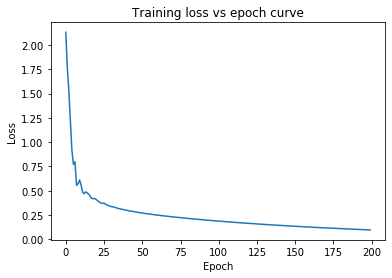

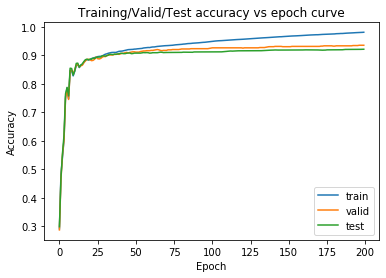

In [26]:
# YOUR CODE HERE
# reload features and targets
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainTargetOneHot, validTargetOneHot, testTargetOneHot = convertOneHot(trainTarget, validTarget, testTarget)

# initialize hidden layer weights
numNodesInHidden = (trainData.shape[1] * trainData.shape[2]) + 1
numNodesOutHidden = 1000
sigmaHidden = np.sqrt(2/(numNodesInHidden + numNodesOutHidden + 1))
WHiddenInit = np.random.normal(loc=0.0, scale=sigmaHidden, size=(numNodesInHidden, numNodesOutHidden))

# initialize output layer weights
numNodesInOutput = numNodesOutHidden + 1
numNodesOutOutput = 10
sigmaOut = np.sqrt(2/(numNodesInOutput + numNodesOutOutput + 1))
WOutputInit = np.random.normal(loc=0.0, scale=sigmaOut, size=(numNodesInOutput, numNodesOutOutput))

# set up number of iterations, alpha, eta
numIter = 200
alpha = 0.9
eta = 1e-5

# flatten features
trainData = np.transpose(np.reshape(trainData, (trainData.shape[0], trainData.shape[1]*trainData.shape[2])))
validData = np.transpose(np.reshape(validData, (validData.shape[0], validData.shape[1]*validData.shape[2])))
testData = np.transpose(np.reshape(testData, (testData.shape[0], testData.shape[1]*testData.shape[2])))

# sanity check on features and targets
assert trainData.shape[0]==784 and validData.shape[0]==784 and testData.shape[0]==784
print(f"Number of training images: {trainData.shape[1]}")
print(f"Number of validation images: {validData.shape[1]}")
print(f"Number of test images: {testData.shape[1]}")
assert trainTargetOneHot.shape[0]==10 and validTargetOneHot.shape[0]==10 and testTargetOneHot.shape[0]==10

# train
WHiddenFinal, WOutputFinal, trainLosses, trainAccs, validAccs, testAccs = train(trainData, trainTargetOneHot, WHiddenInit, WOutputInit, numIter, eta, alpha, validData, validTargetOneHot, testData, testTargetOneHot)

# visualize training loss
fig = plt.figure(0)
ax = fig.add_subplot(1, 1, 1)
ax.plot(trainLosses)
ax.set_title('Training loss vs epoch curve')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.savefig('train_loss.png')

# visualize training/validation/test accuracy
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)
ax.plot(trainAccs, label='train')
ax.plot(validAccs, label='valid')
ax.plot(testAccs, label='test')
ax.legend(loc='best')
ax.set_title('Training/Valid/Test accuracy vs epoch curve')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.savefig('train+valid+test_acc.png')

![loss](train_loss.png)
![acc](train+valid+test_acc.png)

- Final training accuracy: 93.85%
- Final validation accuracy: 90.37%
- Final test accuracy: 89.54%

## Hyperparameter investigation [3 points]

Continue to use $\alpha=0.9$ and $\eta=10^{-5}$.

Test your network with 500 and 1500 hidden nodes and train for 200 epochs. Comment based on the validation accuracy after how many epochs training could be terminated early. 

Plot the training and validation accuracy curves for all three network sizes (500, 1000, 1500) and 200 training epochs, and report the test accuracy for your selected network size and training length. Show the plots and state the final accuracies in the next text cell.

Training with 500 nodes in the hidden layer for 100 iterations
Final training accuracy: 94.33%
Final validation accuracy: 92.10%
Final test accuracy: 91.23%
Training with 1000 nodes in the hidden layer for 100 iterations
Final training accuracy: 94.49%
Final validation accuracy: 91.90%
Final test accuracy: 91.01%
Training with 1500 nodes in the hidden layer for 100 iterations
Final training accuracy: 94.96%
Final validation accuracy: 92.40%
Final test accuracy: 91.34%
Training with 500 nodes in the hidden layer for 300 iterations
Final training accuracy: 99.09%
Final validation accuracy: 93.00%
Final test accuracy: 92.03%
Training with 1000 nodes in the hidden layer for 300 iterations
Final training accuracy: 99.32%
Final validation accuracy: 93.50%
Final test accuracy: 91.92%
Training with 1500 nodes in the hidden layer for 300 iterations
Final training accuracy: 99.48%
Final validation accuracy: 93.80%
Final test accuracy: 92.07%


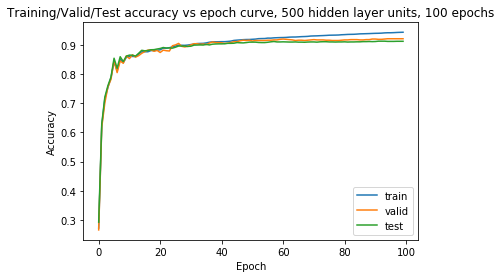

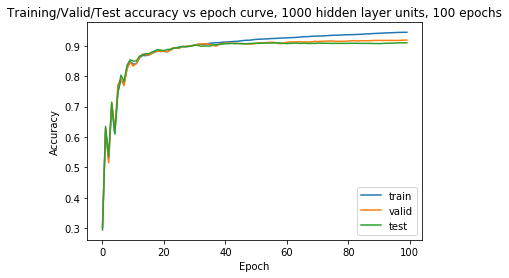

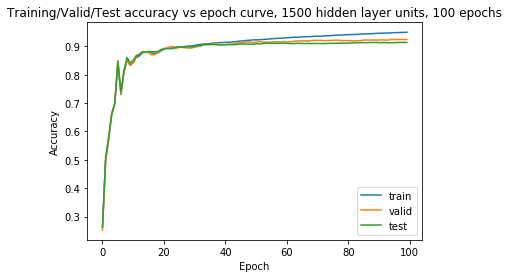

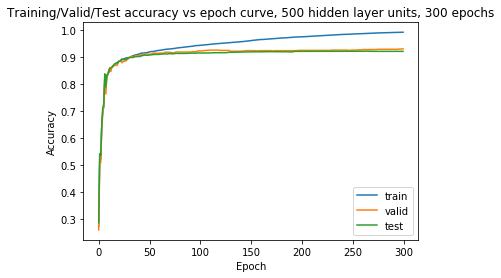

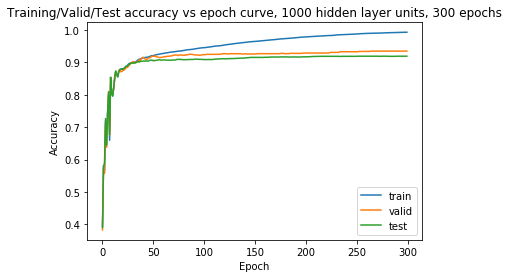

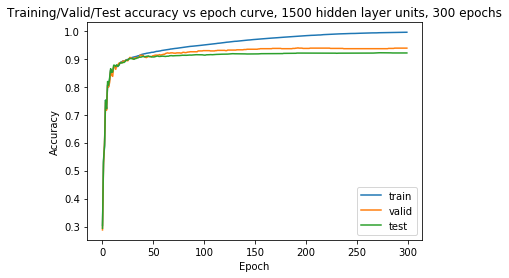

In [27]:
# YOUR CODE HERE
def initWeights(sizeIn, sizeHidden, sizeOutput):
    """
    Return initial weight matrices for the hidden layer 
    and the output layer. We use Xavier initialization
    here.
    Inputs:
    - sizeIn: number of input features, d(0)
    - sizeHidden: number of nodes in the hidden layer,
      d(1)
    - sizeOutput: number of nodes in the output layer,
      d(L)
    Returns:
    - WHidden: hidden layer weights of shape (d(0)+1, d(1))
    - WOutput: output layer weights of shape (d(1)+1, d(L))
    """
    # initialize hidden layer weights
    numNodesInHidden = sizeIn + 1
    numNodesOutHidden = sizeHidden
    sigmaHidden = np.sqrt(2/(numNodesInHidden + numNodesOutHidden + 1))
    WHidden = np.random.normal(loc=0.0, scale=sigmaHidden, size=(numNodesInHidden, numNodesOutHidden))

    # initialize output layer weights
    numNodesInOutput = numNodesOutHidden + 1
    numNodesOutOutput = sizeOutput
    sigmaOut = np.sqrt(2/(numNodesInOutput + numNodesOutOutput))
    WOutput = np.random.normal(loc=0.0, scale=sigmaOut, size=(numNodesInOutput, numNodesOutOutput))
    return (WHidden, WOutput)

# test code for initWeights
w1, wl = initWeights(3, 20, 4)
assert w1.shape == (4, 20) and wl.shape == (21, 4)

# reload features and targets
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainTargetOneHot, validTargetOneHot, testTargetOneHot = convertOneHot(trainTarget, validTarget, testTarget)

# flatten features
trainData = np.transpose(np.reshape(trainData, (trainData.shape[0], trainData.shape[1]*trainData.shape[2])))
validData = np.transpose(np.reshape(validData, (validData.shape[0], validData.shape[1]*validData.shape[2])))
testData = np.transpose(np.reshape(testData, (testData.shape[0], testData.shape[1]*testData.shape[2])))

# initialize other hyperparams
eta = 1e-5
alpha = 0.9

def trainWithVariableEpoch(numIter, eta, alpha, trainData, trainTargetOneHot, validData, validTargetOneHot, testData, testTargetOneHot):
    """
    Train on 500, 1k, 1.5k hidden layer units for 
    specified number of epochs. Save accuracy vs.
    epoch curves to 
    train+valid+test_acc_<hidden layer size>_<epoch>.png
    """
    for sizeHidden in [500, 1000, 1500]:    
        # initialize weights
        WHiddenInit, WOutputInit = initWeights(trainData.shape[0], sizeHidden, 10)

        # train
        print(f"Training with {sizeHidden} nodes in the hidden layer for {numIter} iterations")
        WHiddenFinal, WOutputFinal, trainLosses, trainAccs, validAccs, testAccs = train(trainData, trainTargetOneHot, WHiddenInit, WOutputInit, numIter, eta, alpha, validData, validTargetOneHot, testData, testTargetOneHot)

        # visualize training/validation/test accuracy
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(trainAccs, label='train')
        ax.plot(validAccs, label='valid')
        ax.plot(testAccs, label='test')
        ax.legend(loc='best')
        ax.set_title(f'Training/Valid/Test accuracy vs epoch curve, {sizeHidden} hidden layer units, {numIter} epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        plt.savefig(f'train+valid+test_acc_{sizeHidden}_{numIter}.png')
    

# for the three hidden layer sizes, train for 200 epochs
#trainWithVariableEpoch(200, eta, alpha, trainData, trainTargetOneHot, validData, validTargetOneHot, testData, testTargetOneHot)

# for the three hidden layer sizes, train for 100 epochs
trainWithVariableEpoch(100, eta, alpha, trainData, trainTargetOneHot, validData, validTargetOneHot, testData, testTargetOneHot)

# for the three hidden layer sizes, train for 300 epochs
trainWithVariableEpoch(300, eta, alpha, trainData, trainTargetOneHot, validData, validTargetOneHot, testData, testTargetOneHot)

Accuracies for 200 epochs:

![acc_500](train+valid+test_acc_500_200.png)
![acc_1000](train+valid+test_acc_1000_200.png)
![acc_1500](train+valid+test_acc_1500_200.png)

After training for 200 epochs,
- 500 hidden layer units, final test accuracy: 89.28%
- 1000 hidden layer units, final test accuracy: 89.41%
- 1500 hidden layer units, final test accuracy: 89.38%

We notice from the plots that regardless of hidden layer size, validation accuracy plateaued after 75 to 100 epochs. So we trained again for 100 epochs. We then find with **1500 nodes** in the hidden layer we have the highest accuracies:
- Final training accuracy: 90.30%
- Final validation accuracy: 88.82%
- Final test accuracy: 88.11%